In [52]:
import os
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
import statsmodels.api as sm
from itertools import product
from math import sqrt
from sklearn.metrics import mean_squared_error 

In [53]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [54]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
df = pd.read_csv('all_currencies.csv', parse_dates=['Date'], index_col='Date', date_parser=dateparse)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [55]:
df.head()

,Symbol,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,,
2015-11-12,$$$,0.000013,0.000017,0.000013,0.000017,142.0,NaN
2015-11-13,$$$,0.000017,0.000033,0.000016,0.000024,85.0,NaN
2015-11-14,$$$,0.000024,0.000053,0.000023,0.000030,131.0,NaN
2015-11-15,$$$,0.000030,0.000063,0.000022,0.000035,132.0,NaN
2015-11-16,$$$,0.000035,0.000046,0.000032,0.000036,280.0,NaN


In [56]:
btc=df[df['Symbol']=='BTC']
# Drop some columns
btc.drop(['Volume', 'Market Cap'],axis=1,inplace=True) 

In [57]:
btc_month = btc.resample('M').mean()

Dickey–Fuller test: p=0.943465


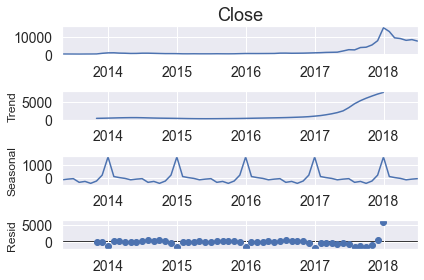

In [58]:
seasonal_decompose(btc_month.Close, model='additive').plot()
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.Close)[1])
## Dickey–Fuller test, tests the null hypothesis that a unit root is present in an autoregressive time series model.

In [59]:
## I have learned about Box Cox transformation. which is a family of power transformations indexed by a parameter lambda.Below using Box-Cox Transformation cancel so of the variance.   

In [60]:
btc_month['close_box'], lmbda = stats.boxcox(btc_month.Close)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.close_box)[1])

Dickey–Fuller test: p=0.509378


In [61]:
btc_month['box_diff_seasonal_12'] = btc_month.close_box - btc_month.close_box.shift(12)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff_seasonal_12[12:])[1])

Dickey–Fuller test: p=0.155278


In [62]:
btc_month['box_diff_seasonal_3'] = btc_month.close_box - btc_month.close_box.shift(3)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff_seasonal_3[3:])[1])

Dickey–Fuller test: p=0.012923


Dickey–Fuller test: p=0.081588


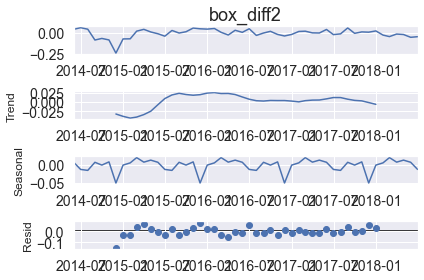

In [63]:
btc_month['box_diff2'] = btc_month.box_diff_seasonal_12 - btc_month.box_diff_seasonal_12.shift(1)

# STL-decomposition
seasonal_decompose(btc_month.box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff2[13:])[1])

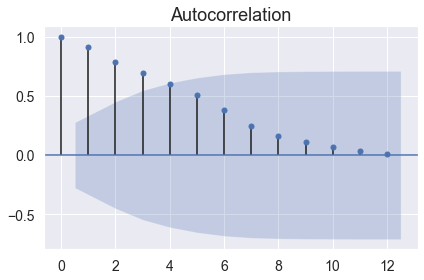

In [64]:
#autocorrelation_plot(btc_month.close)
plot_acf(btc_month.Close[13:].values.squeeze(), lags=12)
plt.tight_layout()

In [65]:
# Initial approximation of parameters
qs = range(0, 3)
ps = range(0, 3)
d=1
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = SARIMAX(btc_month.close_box, order=(param[0], d, param[1])).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [66]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

  parameters         aic
3     (1, 0) -225.144309
1     (0, 1) -224.700279
4     (1, 1) -223.182403
6     (2, 0) -223.174193
2     (0, 2) -222.933808


In [67]:
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:              close_box   No. Observations:                   63
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 114.572
Date:                Sat, 14 Aug 2021   AIC                           -225.144
Time:                        22:40:31   BIC                           -220.890
Sample:                    04-30-2013   HQIC                          -223.474
                         - 06-30-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3737      0.147      2.548      0.011       0.086       0.661
sigma2         0.0014      0.000     11.839      0.000       0.001       0.002
Ljung-Box (L1) (Q):                   0.02   Jarque-

In [68]:
print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[13:])[1])

Dickey–Fuller test:: p=0.000000


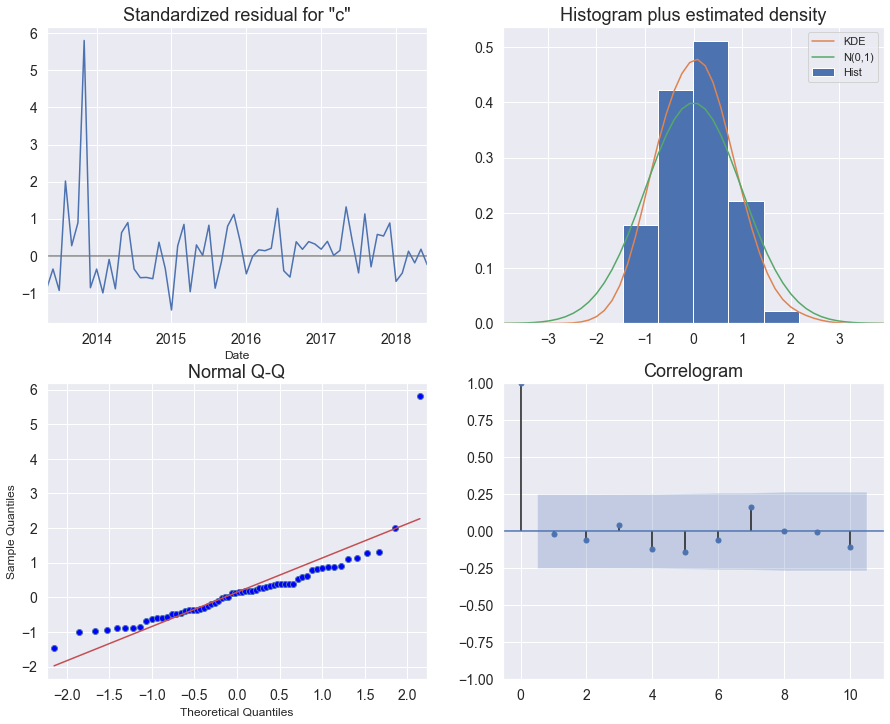

In [69]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [70]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Text(0, 0.5, 'USD')

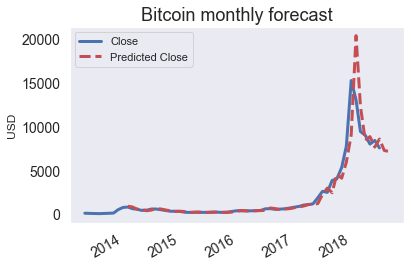

In [71]:
# Prediction
btc_month_pred = btc_month[['Close']]
date_list = [datetime(2018, 6, 30), datetime(2018, 7, 31), datetime(2018, 8, 31)]
future = pd.DataFrame(index=date_list, columns= btc_month.columns)
btc_month_pred = pd.concat([btc_month_pred, future])

btc_month_pred['forecast'] = invboxcox(best_model.predict(start=datetime(2014, 1, 31), end=datetime(2018, 8, 31)), lmbda)

btc_month_pred.Close.plot(linewidth=3)
btc_month_pred.forecast.plot(color='r', ls='--', label='Predicted Close', linewidth=3)
plt.legend()
plt.grid()
plt.title('Bitcoin monthly forecast')
plt.ylabel('USD')